In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

from google.colab import drive

In [0]:
#To load and save simulation data

drive.mount('/content/gdrive')
DATA_PATH = '/content/gdrive/My Drive/MSc. Szakdolgozat/Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#To make nice images
font = {'size'   : 16}
plt.rc('font', **font)

The goal with this project is to interpolate missiong points of the CIR phase diagram, and thus reducing the neccesary amount of Monte Carlo simulations needed to have an adecvate picture of the transition.

Why use ML for this?
As we will see, the connection between the $dt$, $\gamma$ and $P$  is non-trivial and also dependant on the discretization method, so a simple function fitting would be insufficent,therefore we turn to ML.

# Train and validation data

In [0]:
model = 'CIR_'
name = 'ML_6'
df= pd.read_csv(f"{DATA_PATH}{model}{name}.csv")

#This is one of the better simualtions, that I've done

In [0]:
df = df.drop(["X0","T","P_T"], axis = 1)                                        #These are unnecesary

In [0]:
df.P_bulk = list(map(lambda p: 1-p,df.P_bulk))                                  #Instead of P_bulk, we calculate P_boundary, since it's easier to understand.
df = df.rename(columns = {"P_bulk" : "P_boundary"})

## Visualazig what's going on

In [0]:
P = np.zeros((25,20))
for i in range(0,25):
  for j in range(0,20):
    P[i,j] = df["P_boundary"][i*20+j]

dt = np.zeros((25,20))
for i in range(0,25):
  for j in range(0,20):
    dt[i,j] = np.logspace(np.log10(0.1),np.log10(0.0001),25)[i]

gamma = np.zeros((25,20))
for i in range(0,25):
  for j in range(0,20):
    gamma[i,j] = np.linspace(0.1,2,20)[j]

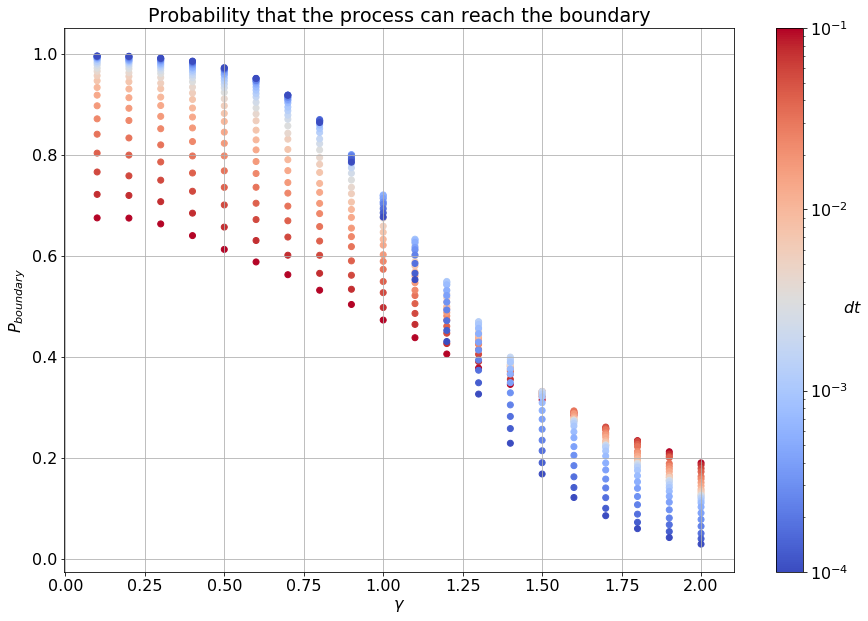

In [0]:
plt.figure(figsize=(15,10))
for i in range(0,25):
  plt.scatter(np.linspace(0.1,2,20),P[i,:], c = dt[i], norm=colors.LogNorm(vmin=dt.min(),vmax=dt.max()), cmap = "coolwarm")

cbar = plt.colorbar()
cbar.set_label("$dt$", rotation = 0)

plt.title("Probability that the process can reach the boundary")
plt.xlabel("$\gamma$")
plt.ylabel("$P_{boundary}$")
plt.grid()

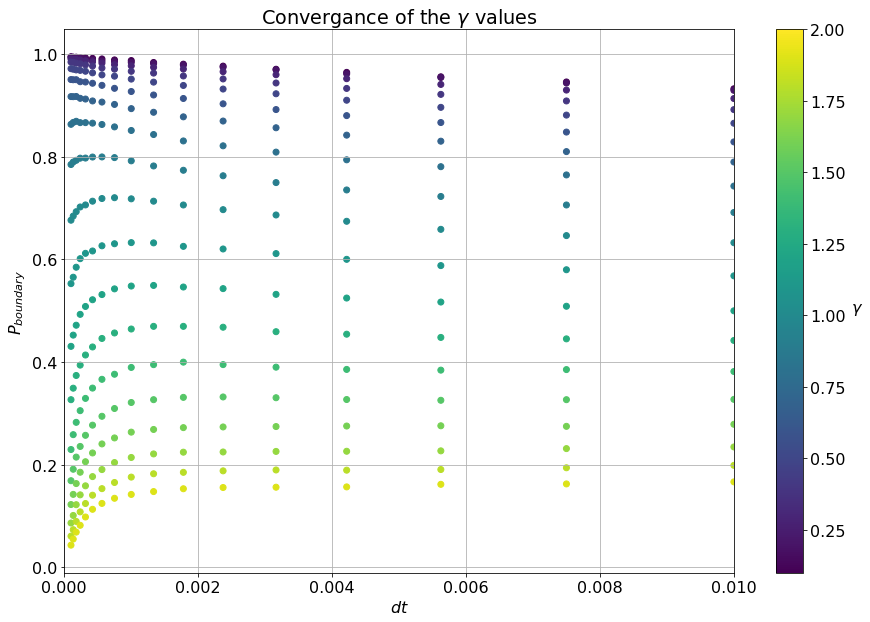

In [0]:
plt.figure(figsize=(15,10))
for i in range(0,19):
  plt.scatter(np.logspace(np.log10(0.1),np.log10(0.0001),25),P[:,i],c = gamma[:,i], norm=colors.Normalize(vmin=gamma.min(),vmax=gamma.max()))

cbar = plt.colorbar()
cbar.set_label("   $\gamma$", rotation = 0)

plt.title("Convergance of the $\gamma$ values")
plt.xlabel("$dt$")
plt.xlim((0,0.01))
plt.ylabel("$P_{boundary}$")
plt.grid()

As we can see there is a non-trivial convergance of the datapoints as a function of dt, and if we wanted to see the $dt\rightarrow0$ limit we should turn to series acceleration methods. One of the possibilities is the Aitken's delta-squared process, which performs better the more datapoints we have. So we will try to generate more datapoints with a good ML model.

## Preparing the data

In [0]:
#The goal is to have data for many more gamma and dt values, since it is very expansive to run MC simualtions, for getting any new point

dt_new = np.logspace(np.log10(0.1),np.log10(0.0001),100)
gamma_new = np.linspace(0.1,2,100)

data_new = np.zeros((len(dt_new)*len(gamma_new),3))

for i in range(len(dt_new)):
  for j in range(len(gamma_new)):
    data_new[i*len(gamma_new)+j,0] = dt_new[i]
    data_new[i*len(gamma_new)+j,1] = gamma_new[j]
    data_new[i*len(gamma_new)+j,2] = -999 #This is what we want to eventually extrapolate, so it's value doesn't matter
data_new = pd.DataFrame(data = data_new, columns = ["dt","gamma","P_boundary"])

In [0]:
dlen = len(df)
df = df.append(data_new,ignore_index=True)
df_scaled = df.copy()

In [0]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

X = df_scaled.drop("P_boundary", axis = 1)
df_scaled[X.columns] = StandardScaler().fit_transform(X)
del X

In [0]:
#Splitting the data for training, and eventual regression:
X = df_scaled.drop("P_boundary", axis = 1).iloc[range(0,dlen)]             #This is the data used for training, and model selection
y = df_scaled.P_boundary.iloc[range(0,dlen)]
X_reg = df_scaled.drop("P_boundary", axis = 1).iloc[range(dlen,len(df))]   #This is the data we want to predict, so we can have better converging series.

# Model selection

In [0]:
 from sklearn.metrics import mean_absolute_error
 from sklearn.model_selection import KFold

In this segment we will look at the performance of many popular regression models, and will evaluate them based on the mean absolute error of their predictions with a leave-one-out cross-validation.

## Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
model = LinearRegression()

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
lin_score = np.mean(maes)
print(lin_score)

0.06379703941675793


## KNN

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [0]:
model = KNeighborsRegressor()

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
knn_score = np.mean(maes)
print(knn_score)

0.012408799999999998


## RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
model = RandomForestRegressor()

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
forest_score = np.mean(maes)
print(forest_score)

0.006537478190476187


## XGboost

### XGB Tree

In [0]:
from xgboost import XGBRegressor

In [0]:
model = XGBRegressor(objective='reg:squarederror')

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
xgb_tree_score = np.mean(maes)
print(xgb_tree_score)

0.006470973961925507


### XGB Forest

In [0]:
from xgboost import XGBRFRegressor

In [0]:
model = XGBRFRegressor()

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
xgb_forest_score = np.mean(maes)
print(xgb_forest_score)

0.08820882065610886


## Simple neural network

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
model = MLPRegressor()

maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
mlp_score = np.mean(maes)
print(mlp_score)

0.039089509491696844


## Comparing the models

In [0]:
model_names = ["LinReg","KNN","RandomForest","XGBoost","XGBoost_Forest","MLP"]
model_scores = [lin_score,knn_score,forest_score,xgb_tree_score,xgb_forest_score,mlp_score]

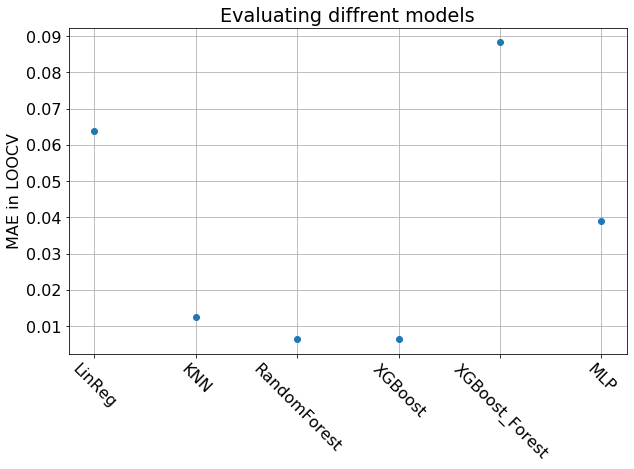

In [0]:
plt.figure(figsize=(10,6))
plt.plot(model_names,model_scores, "o")

plt.title("Evaluating diffrent models")
plt.xticks(rotation = -45)
plt.ylabel("MAE in LOOCV")

plt.grid()

Based on these findings is will tune the **XGBoost** model to improve on its performance further.

# Hyperparameter tuning

In [0]:
from xgboost import XGBRegressor

## Max Depth

In [0]:
max_depth_list = [3,4,5,6,7,8,9,10]
mae_list = []

for md in max_depth_list:
  model = XGBRegressor(max_depth=md,n_jobs = 4,objective='reg:squarederror')
  
  maes = []
  kf = KFold(n_splits=len(X), random_state=42)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))
  mae_list.append(np.mean(maes))

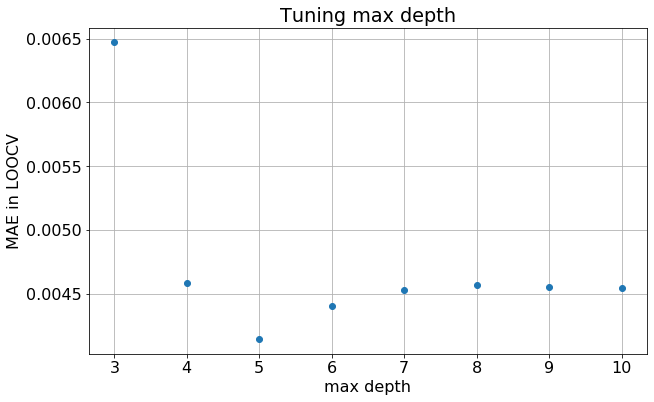

In [0]:
plt.figure(figsize=(10,6))
plt.plot(max_depth_list,mae_list, "o")

plt.title("Tuning max depth")
plt.xlabel("max depth")
plt.ylabel("MAE in LOOCV")

plt.grid()

Optimal max_depth is 5

## n_estimators

In [0]:
n_estimators_list = [100,200,300,400,500,600,700,800,900,1000]
mae_list = []

for k in n_estimators_list:
  model = XGBRegressor(max_depth=5,n_estimators=k,n_jobs = 4,objective='reg:squarederror')
  
  maes = []
  kf = KFold(n_splits=len(X), random_state=42)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))
  mae_list.append(np.mean(maes))

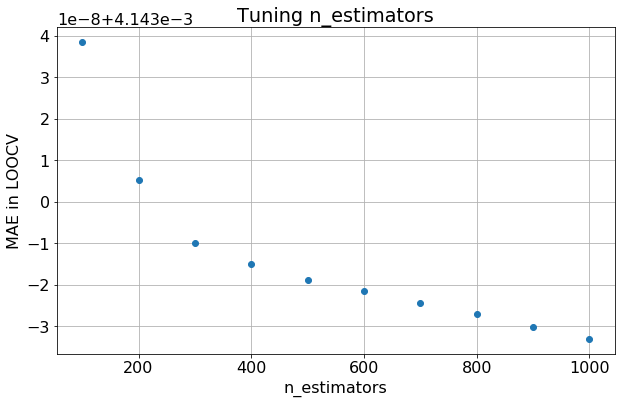

In [0]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_list,mae_list, "o")

plt.title("Tuning n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("MAE in LOOCV")

plt.grid()

The MAE is reduced as the number of estimator is increased, however at a very high computation time penalty, so here it is worth choosing something that should be "fast enough".

## How good is it now?

In [0]:
#The model I will use:
model = XGBRegressor(max_depth=5,n_estimators=500,n_jobs = 4,objective='reg:squarederror')
  
maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  model.fit(X_train, y_train)
  maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/x

In [0]:
print(np.mean(maes))

0.004142981084251405


In [0]:
min(y)

0.029900000000000038

This model has smaller absolute error, than the smallest P that we need to predict.

## Testing the model on data with diffrent discretization

### WMS

In [0]:
model = 'CIR_'
name = 'ML_WMS'
df_0= pd.read_csv(f"{DATA_PATH}{model}{name}.csv")

df_0 = df_0.drop(["X0","T","P_T"], axis = 1)

df_0.P_bulk = list(map(lambda p: 1-p,df_0.P_bulk))
df_0 = df_0.rename(columns = {"P_bulk" : "P_boundary"})


X = df_0.drop("P_boundary", axis = 1)
df_0[X.columns] = StandardScaler().fit_transform(X)
del X

X = df_0.drop("P_boundary", axis = 1)
y = df_0.P_boundary

model = XGBRegressor(max_depth=5,n_estimators=500,n_jobs = 4,objective='reg:squarederror')
  
maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  model.fit(X_train, y_train)
  maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
print(np.mean(maes))

0.0009957678232192986


### BIS

In [0]:
model = 'CIR_'
name = 'ML_BIS'
df_1= pd.read_csv(f"{DATA_PATH}{model}{name}.csv")

df_1 = df_1.drop(["X0","T","P_T"], axis = 1)

df_1.P_bulk = list(map(lambda p: 1-p,df_1.P_bulk))
df_1 = df_1.rename(columns = {"P_bulk" : "P_boundary"})


X = df_1.drop("P_boundary", axis = 1)
df_1[X.columns] = StandardScaler().fit_transform(X)
del X

X = df_1.drop("P_boundary", axis = 1)
y = df_1.P_boundary

model = XGBRegressor(max_depth=5,n_estimators=500,n_jobs = 4,objective='reg:squarederror')
  
maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  model.fit(X_train, y_train)
  maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
print(np.mean(maes))

0.0005588387371063221


### PALQ

In [0]:
model = 'CIR_'
name = 'ML_PALQ'
df_2= pd.read_csv(f"{DATA_PATH}{model}{name}.csv")

df_2 = df_2.drop(["X0","T","P_T"], axis = 1)

df_2.P_bulk = list(map(lambda p: 1-p,df_2.P_bulk))
df_2 = df_2.rename(columns = {"P_bulk" : "P_boundary"})


X = df_2.drop("P_boundary", axis = 1)
df_2[X.columns] = StandardScaler().fit_transform(X)
del X

X = df_2.drop("P_boundary", axis = 1)
y = df_2.P_boundary

model = XGBRegressor(max_depth=5,n_estimators=500,n_jobs = 4,objective='reg:squarederror')
  
maes = []
kf = KFold(n_splits=len(X), random_state=42)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  model.fit(X_train, y_train)
  maes.append(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test)))

In [0]:
print(np.mean(maes))

0.004339416711235045


# Predicting new values with the optimal model

In [0]:
model = XGBRegressor(max_depth=5,n_estimators=500,n_jobs = 4,objective='reg:squarederror')

model.fit(X,y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_reg)
df.P_boundary.iloc[range(dlen,len(df))] = y_pred

In [0]:
#These are the predicted probabilites using XGBoost
P = np.zeros((100,100))
for i in range(0,100):
  for j in range(0,100):
    P[i,j] = df["P_boundary"][500+i*100+j]

dt = np.zeros((100,100))
for i in range(0,100):
  for j in range(0,100):
    dt[i,j] = dt_new[i]

gamma = np.zeros((100,100))
for i in range(0,100):
  for j in range(0,100):
    gamma[i,j] = gamma_new[j]

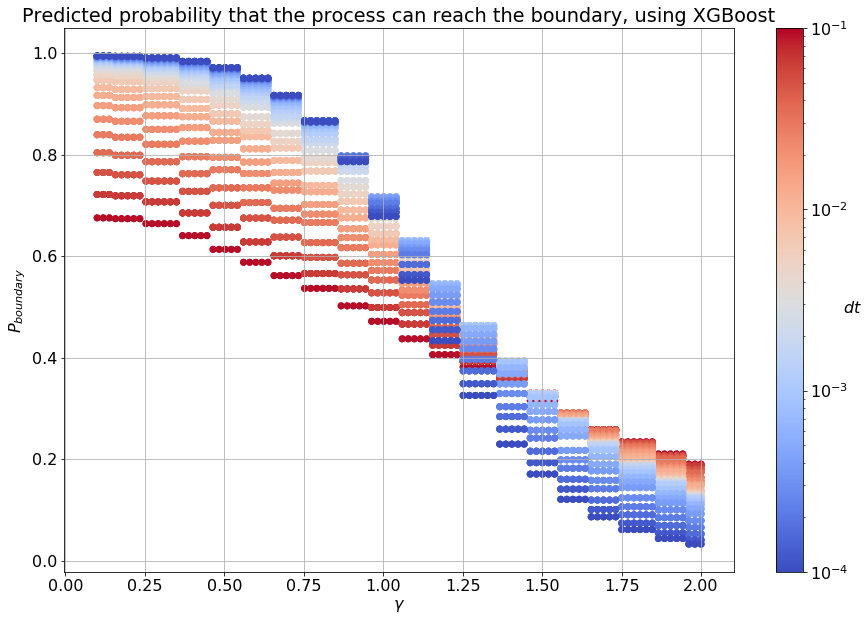

In [0]:
plt.figure(figsize=(15,10))
for i in range(0,100):
  plt.scatter(np.linspace(0.1,2,100),P[i,:], c = dt[i], norm=colors.LogNorm(vmin=dt.min(),vmax=dt.max()), cmap = "coolwarm")

cbar = plt.colorbar()
cbar.set_label("$dt$", rotation = 0)

plt.title("Predicted probability that the process can reach the boundary, using XGBoost")
plt.xlabel("$\gamma$")
plt.ylabel("$P_{boundary}$")
plt.grid()

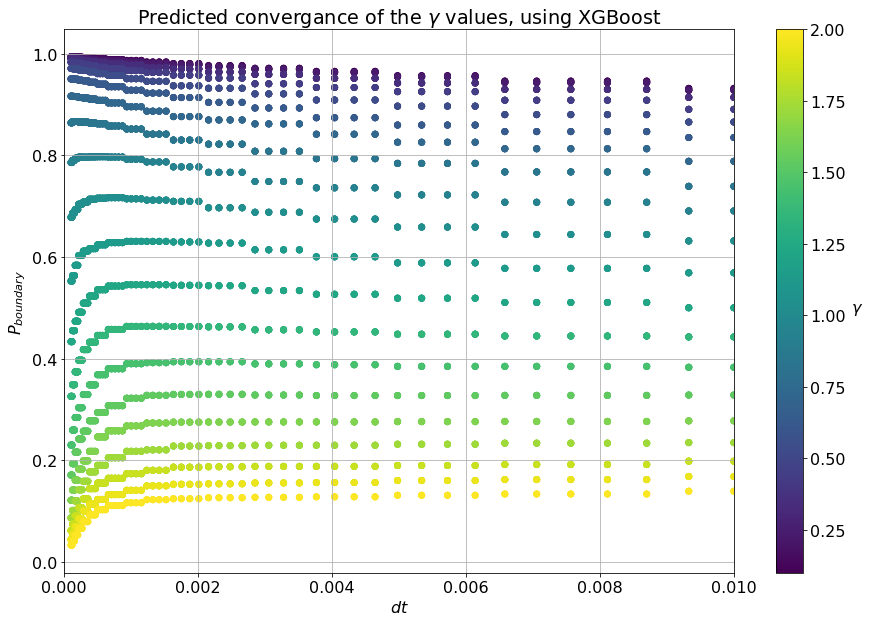

In [0]:
plt.figure(figsize=(15,10))
for i in range(0,100):
  plt.scatter(np.logspace(np.log10(0.1),np.log10(0.0001),100),P[:,i],c = gamma[:,i], norm=colors.Normalize(vmin=gamma.min(),vmax=gamma.max()))

cbar = plt.colorbar()
cbar.set_label("   $\gamma$", rotation = 0)

plt.title("Predicted convergance of the $\gamma$ values, using XGBoost")
plt.xlabel("$dt$")
plt.xlim((0,0.01))
plt.ylabel("$P_{boundary}$")
plt.grid()

On the first image we can see, that the model overfits, and predicts the same $P$ value for every point aroind a "known" one. This is not what I expected, but it is still worth checking, wether the series acceleration algorithm improves or not.

## Series acceleration

In [0]:
#Series Acceleration
#Aitken Delta square process:
def Aitken_Delta_Sq(X,eps):
  AX = []
  for i in range(len(X)-2):
    denominator = (X[i+2]-X[i+1])-(X[i+1]-X[i])
    if denominator < eps:                                                       #No small denominator
      ax = X[i+2] - np.power(X[i+2]-X[i+1],2)/denominator
      if ax > 0:                                                                #No negative elements
        AX.append(ax)
  return AX

In [0]:
EPSILON = 0.0001
l = []
for j in range(20):
  ads = Aitken_Delta_Sq(P_1[:,j],EPSILON)
  l.append(np.mean([ads[len(ads)-1],ads[len(ads)-2],ads[len(ads)-3]]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [0]:
EPSILON = 0.001
gamma = np.linspace(0.1,2,100)

l_new = []
for j in range(100):
  if (j%5)==2:                                 #Getting rid of the steps
    ads = Aitken_Delta_Sq(P[:,j],EPSILON)
    l_new.append(np.mean(ads))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


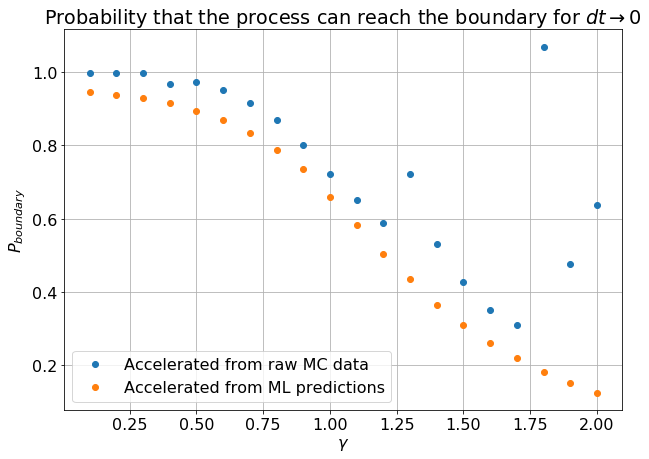

In [0]:
plt.figure(figsize=(10,7))

plt.plot(np.linspace(0.1,2,20),l,"o",label = "Accelerated from raw MC data")
plt.plot(np.linspace(0.1,2,20),l_new,"o",label = "Accelerated from ML predictions")

plt.title("Probability that the process can reach the boundary for $dt \\rightarrow 0$")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("$P_{boundary}$")
plt.grid()

While we noted that the predictions are weak for predicting new datapoints for unknown $\gamma$ values they seem to be good for predicting for new $dt$-s, which is in turn good for the series acceleration methods, since there is more datapoints for the extrapolation.